In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
from PIL import Image
import csv
import random
import kagglehub
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import pandas as pd
import torchvision.utils as vutils

# Ensure output directory exists for the new CVAE-based IID setup
output_dir_cvae_iid = "FL_VEHICLE_CVAE_IID"
os.makedirs(output_dir_cvae_iid, exist_ok=True)

# Load the previous converted IID results
prev_converted_iid_path = r"C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv"
try:
    prev_converted_iid_df = pd.read_csv(prev_converted_iid_path)
    communication_rounds_prev_converted_iid = prev_converted_iid_df['Communication Rounds'].tolist()
    global_accuracies_prev_converted_iid = prev_converted_iid_df['Global Accuracies'].tolist()
    global_losses_prev_converted_iid = prev_converted_iid_df['Global Losses'].tolist()
    print(f"Loaded previous converted IID results from {prev_converted_iid_path}")
except Exception as e:
    print(f"Failed to load previous converted IID results from {prev_converted_iid_path}: {e}")
    raise

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Base transform for RGB Vehicle Type Dataset (used for CNN)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for CVAE (keep data in [0, 1], flatten spatial dimensions)
cvae_input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # [0, 1]
])
cvae_flatten_transform = transforms.Lambda(lambda x: x.view(x.size(0), -1))

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Original Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        if not self.images:
            raise ValueError(f"No images found in {root_dir}.")

        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the Vehicle Type Dataset with CVAE input transform for splitting
dataset_cvae = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset_cvae.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset_cvae)):
    label = dataset_cvae.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap between train, val, and test
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create datasets for CVAE (train) and CNN (val/test)
train_dataset_cvae = Subset(dataset_cvae, [idx for class_indices in train_indices_per_class for idx in class_indices])
dataset_cnn = VehicleTypeDataset(root_dir=dataset_path, transform=base_transform)
val_dataset = Subset(dataset_cnn, [idx for class_indices in val_indices_per_class for idx in class_indices])
test_dataset = Subset(dataset_cnn, [idx for class_indices in test_indices_per_class for idx in class_indices])

print(f"Training samples (CVAE): {len(train_dataset_cvae)}")
print(f"Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Create per-class training datasets for CVAE
train_class_datasets = []
for class_idx in range(label_dim):
    class_dataset = Subset(train_dataset_cvae, train_indices_per_class[class_idx])
    train_class_datasets.append(class_dataset)

# Define subsample_dataset function before using it
def subsample_dataset(dataset, target_length):
    if len(dataset) <= target_length:
        return dataset
    indices = random.sample(range(len(dataset)), target_length)
    return Subset(dataset, indices)

# Subsample each class dataset to 500 samples
target_samples_per_class = 500
train_class_datasets = [subsample_dataset(dataset, target_samples_per_class) for dataset in train_class_datasets]

# CVAE Configuration
original_dim = 128 * 128 * 3  # 128x128 RGB images
intermediate_dim = 512
latent_dim = 20
batch_size = 100
epochs = 3000
learning_rate = 1e-3
beta = 0.5
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Define CVAE classes
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, label_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, label_dim, hidden_dim, output_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, y):
        z_mean, z_logvar = self.encoder(x, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

def cvae_loss(x, x_reconstructed, z_mean, z_logvar, beta=beta):
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + beta * kl_loss

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 2],  # User 1
    1: [1, 2, 3],  # User 2
    2: [2, 3, 4],  # User 3
    3: [3, 4, 0],  # User 4
    4: [4, 0, 1]   # User 5
}

cvae_users = {}
for user_idx in range(Num_users):
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True)
    
    cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    checkpoint_dir = f'./checkpoints_cvae_user{user_idx + 1}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'cvae_user{user_idx + 1}_final.pth')
    
    if os.path.exists(checkpoint_path):
        print(f"Loading pre-trained CVAE for User {user_idx + 1}...")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        cvae.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        print(f"Training CVAE for User {user_idx + 1}...")
        for epoch in range(epochs):
            cvae.train()
            total_loss = 0
            for data, labels in user_loader:
                data = data.to(device)
                data = cvae_flatten_transform(data)
                y = F.one_hot(labels, num_classes=label_dim).float().to(device)
                
                optimizer.zero_grad()
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"User {user_idx + 1}, Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(user_loader.dataset):.4f}")
        torch.save({'model_state_dict': cvae.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
        print(f"CVAE for User {user_idx + 1} saved.")
    
    cvae_users[user_idx] = cvae

# Step 3: Save latent vectors and decoder parameters for each class
for user_idx in range(Num_users):
    cvae = cvae_users[user_idx]
    user_folder = f'./user{user_idx + 1}_cvae'
    os.makedirs(user_folder, exist_ok=True)
    
    torch.save(cvae.decoder.state_dict(), os.path.join(user_folder, 'decoder.pth'))
    
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=False)
    
    latent_vectors = {cls: {'z_mean': [], 'z_logvar': []} for cls in user_classes[user_idx]}
    
    cvae.eval()
    with torch.no_grad():
        for data, labels in user_loader:
            data = data.to(device)
            data = cvae_flatten_transform(data)
            y = F.one_hot(labels, num_classes=label_dim).float().to(device)
            z_mean, z_logvar = cvae.encoder(data, y)
            for i, label in enumerate(labels):
                latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                latent_vectors[label.item()]['z_logvar'].append(z_logvar[i].cpu())
    
    for cls in user_classes[user_idx]:
        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
        torch.save({'z_mean': z_mean, 'z_logvar': z_logvar}, os.path.join(user_folder, f'class_{cls}_latent.pt'))

# Step 4: Share latent vectors and decoder parameters to generate synthetic data
# Define which users have which classes
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme (choose the first user that has the class as the source)
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # Pick the first user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000  # Generate 1000 images
num_synthetic_per_class_select = 500     # Select 500 images

# Generate synthetic data and select top 500 based on mean pixel intensity
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user_idx = scheme['source_user']
    target_users = scheme['target_users']
    
    # Load latent vectors from the source user
    source_folder = f'./user{source_user_idx + 1}_cvae'
    latent_data = torch.load(os.path.join(source_folder, f'class_{class_id}_latent.pt'), weights_only=False)
    print(f"Loaded latent data for User {source_user_idx + 1}, Class {class_id}: z_mean shape = {latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)
    
    # Create a shared CVAE instance for this class
    shared_cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    # Load decoder parameters
    if scheme['share_decoder']:
        decoder_params = torch.load(os.path.join(source_folder, 'decoder.pth'), weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters for User {source_user_idx + 1}, Class {class_id}")
    else:
        print(f"Warning: No decoder shared for User {source_user_idx + 1}, Class {class_id}. Using random decoder.")
    
    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = f'./synthetic_user{user_idx + 1}/class_{class_id}'
        os.makedirs(synthetic_dir, exist_ok=True)
        
        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []
        
        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()  # Compute mean pixel intensity
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)
                
                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")
        
        # Sort images by mean pixel intensity and select top 500
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]  # Sort in descending order
        selected_indices = sorted_indices[:num_synthetic_per_class_select]
        
        # Save the selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                vutils.save_image(synthetic_images[img_idx].view(3, 128, 128), img_path, normalize=True)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue
        
        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        
        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")
            
            def __len__(self):
                return len(self.image_files)
            
            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label
        
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=base_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 5: Prepare user data with real and synthetic datasets
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    real_data = Subset(real_data, range(len(real_data)))  # Transform to CNN-compatible dataset
    real_data = [(base_transform(data[0]), data[1]) for data in real_data]
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

# Verify the converted IID distribution
print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

print("\n=== Class Proportion Variance Across Users (CVAE IID) ===")
class_percentages_all_users = np.array([[count / sum(counts) * 100 for count in counts] for counts in class_counts_per_user])
for class_idx in range(label_dim):
    class_proportions = class_percentages_all_users[:, class_idx]
    variance = np.var(class_proportions)
    print(f"Class {class_idx} proportion variance across users (CVAE IID): {variance:.2f}%")
    if variance > 5:
        print(f"Warning: High variance in Class {class_idx} distribution (should be low for IID).")

# CNN Model for RGB
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, label_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Step 6: Run Federated Learning for CVAE IID Setup
batch_size = 128
num_local_epochs = 3
num_rounds = 15

print("\n=== Running Federated Learning (CVAE IID) ===")
global_model_cvae_iid = CNN().to(device)
local_models_cvae_iid = [CNN().to(device) for _ in range(Num_users)]
communication_rounds_cvae_iid = []
global_accuracies_cvae_iid = []
global_losses_cvae_iid = []

for round in range(num_rounds):
    print(f"Round {round + 1} (CVAE IID)")
    for user_idx in range(Num_users):
        local_models_cvae_iid[user_idx].load_state_dict(global_model_cvae_iid.state_dict())
        local_model = local_models_cvae_iid[user_idx]
        local_tr_data_loader = DataLoader(user_data[user_idx], batch_size=batch_size, shuffle=True)
        local_val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_local_epochs):
            local_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for data, target in local_tr_data_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = output.max(1)
                total_train += target.size(0)
                correct_train += predicted.eq(target).sum().item()

            train_loss = running_loss / len(local_tr_data_loader) if len(local_tr_data_loader) > 0 else float('inf')
            train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0.0

            local_model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data, target in local_val_data_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_model(data)
                    val_loss += criterion(output, target).item()
                    _, predicted = output.max(1)
                    total_val += target.size(0)
                    correct_val += predicted.eq(target).sum().item()

            val_loss /= len(local_val_data_loader) if len(local_val_data_loader) > 0 else 1
            val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0.0
            print(f"User {user_idx + 1}, Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
            scheduler.step()

    global_state_dict = global_model_cvae_iid.state_dict()
    for key in global_state_dict.keys():
        local_state_dicts = [local_model.state_dict() for local_model in local_models_cvae_iid]
        global_state_dict[key] = torch.mean(torch.stack([d[key].float() for d in local_state_dicts]), dim=0)
    global_model_cvae_iid.load_state_dict(global_state_dict)

    global_model_cvae_iid.eval()
    global_loss = 0.0
    global_accuracy = 0.0
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = global_model_cvae_iid(data)
            global_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            global_accuracy += (predicted == labels).sum().item()

    global_accuracy = 100 * global_accuracy / len(test_dataset) if len(test_dataset) > 0 else 0.0
    global_loss /= len(test_loader) if len(test_loader) > 0 else 1
    print(f"Round {round + 1}: Global Test Accuracy (CVAE IID): {global_accuracy:.2f}%, Global Loss: {global_loss:.4f}")
    communication_rounds_cvae_iid.append(round + 1)
    global_accuracies_cvae_iid.append(global_accuracy)
    global_losses_cvae_iid.append(global_loss)

# Step 7: Save Results for CVAE IID and Compare with Previous Converted IID
# Save CVAE IID Results
model_save_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_rgb_sgd_global_model_cvae_iid.pth")
torch.save(global_model_cvae_iid.state_dict(), model_save_path_cvae_iid)
print(f"CVAE IID global model saved to {model_save_path_cvae_iid}")

csv_file_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_cvae_iid.csv")
with open(csv_file_path_cvae_iid, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Communication Rounds', 'Global Accuracies', 'Global Losses'])
    writer.writerows(zip(communication_rounds_cvae_iid, global_accuracies_cvae_iid, global_losses_cvae_iid))

# Compare CVAE IID and Previous Converted IID: Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_accuracies_cvae_iid, marker='x', linestyle='-', color='b', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_accuracies_prev_converted_iid, marker='o', linestyle='--', color='g', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracies (%)')
plt.title('Global Accuracies: CVAE IID vs Previous Converted IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_accuracy_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_accuracy_cvae_iid_vs_prev_converted_iid.png")
plt.savefig(comparison_accuracy_plot)
plt.show()
print(f"Saved accuracy comparison plot to {comparison_accuracy_plot}")

# Compare CVAE IID and Previous Converted IID: Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_losses_cvae_iid, marker='x', linestyle='-', color='r', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_losses_prev_converted_iid, marker='o', linestyle='--', color='c', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.title('Global Losses: CVAE IID vs Previous Converted IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_loss_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_loss_cvae_iid_vs_prev_converted_iid.png")
plt.savefig(comparison_loss_plot)
plt.show()
print(f"Saved loss comparison plot to {comparison_loss_plot}")

Loaded previous converted IID results from C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\

IndexError: list index out of range

In [4]:
##modifying and rerunning the code from user2

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
from PIL import Image
import csv
import random
import kagglehub
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import pandas as pd
import torchvision.utils as vutils

# Ensure output directory exists for the new CVAE-based IID setup
output_dir_cvae_iid = "FL_VEHICLE_CVAE_IID"
os.makedirs(output_dir_cvae_iid, exist_ok=True)

# Load the previous converted IID results
prev_converted_iid_path = r"C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv"
try:
    prev_converted_iid_df = pd.read_csv(prev_converted_iid_path)
    communication_rounds_prev_converted_iid = prev_converted_iid_df['Communication Rounds'].tolist()
    global_accuracies_prev_converted_iid = prev_converted_iid_df['Global Accuracies'].tolist()
    global_losses_prev_converted_iid = prev_converted_iid_df['Global Losses'].tolist()
    print(f"Loaded previous converted IID results from {prev_converted_iid_path}")
except Exception as e:
    print(f"Failed to load previous converted IID results from {prev_converted_iid_path}: {e}")
    raise

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Base transform for RGB Vehicle Type Dataset (used for CNN)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for CVAE (keep data in [0, 1], flatten spatial dimensions)
cvae_input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # [0, 1]
])
cvae_flatten_transform = transforms.Lambda(lambda x: x.view(x.size(0), -1))

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Original Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        if not self.images:
            raise ValueError(f"No images found in {root_dir}.")

        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the Vehicle Type Dataset with CVAE input transform for splitting
dataset_cvae = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset_cvae.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset_cvae)):
    label = dataset_cvae.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap between train, val, and test
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create datasets for CVAE (train) and CNN (val/test)
train_dataset_cvae = Subset(dataset_cvae, [idx for class_indices in train_indices_per_class for idx in class_indices])
dataset_cnn = VehicleTypeDataset(root_dir=dataset_path, transform=base_transform)
val_dataset = Subset(dataset_cnn, [idx for class_indices in val_indices_per_class for idx in class_indices])
test_dataset = Subset(dataset_cnn, [idx for class_indices in test_indices_per_class for idx in class_indices])

print(f"Training samples (CVAE): {len(train_dataset_cvae)}")
print(f"Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Create per-class training datasets for CVAE and subsample to 500 samples
target_samples_per_class = 500
train_class_datasets = []

for class_idx in range(label_dim):
    # Get the indices for this class
    class_indices = train_indices_per_class[class_idx]
    # Subsample directly from the original dataset to avoid nested Subsets
    if len(class_indices) > target_samples_per_class:
        class_indices = random.sample(class_indices, target_samples_per_class)
    class_dataset = Subset(dataset_cvae, class_indices)
    train_class_datasets.append(class_dataset)
    print(f"Class {class_idx} subsampled dataset length: {len(class_dataset)}")

# CVAE Configuration
original_dim = 128 * 128 * 3  # 128x128 RGB images
intermediate_dim = 512
latent_dim = 20
batch_size = 100
epochs = 3000  # Corrected to match the intended number of epochs
learning_rate = 1e-3
beta = 0.5
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Define CVAE classes
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, label_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, label_dim, hidden_dim, output_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, y):
        z_mean, z_logvar = self.encoder(x, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

def cvae_loss(x, x_reconstructed, z_mean, z_logvar, beta=beta):
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + beta * kl_loss

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 2],  # User 1
    1: [1, 2, 3],  # User 2
    2: [2, 3, 4],  # User 3
    3: [3, 4, 0],  # User 4
    4: [4, 0, 1]   # User 5
}

cvae_users = {}
for user_idx in range(Num_users):
    # Create user dataset by combining the class datasets
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    print(f"User {user_idx + 1} dataset length: {len(user_dataset)}")
    
    # Validate indices by accessing a few samples
    try:
        for i in range(min(5, len(user_dataset))):
            sample, label = user_dataset[i]
            print(f"User {user_idx + 1}, Sample {i}: Label={label}, Data shape={sample.shape}")
    except Exception as e:
        print(f"Error accessing samples for User {user_idx + 1}: {e}")
        raise

    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True)
    
    cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    checkpoint_dir = f'C:\\Users\\hp\\Desktop\\fedavg\\checkpoints_cvae_user{user_idx + 1}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'cvae_user{user_idx + 1}_final.pth')
    
    if user_idx == 0:
        # Load the pre-trained model for User 1
        print(f"Loading pre-trained CVAE for User 1 from {checkpoint_path}...")
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            cvae.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Successfully loaded pre-trained CVAE for User 1.")
        except Exception as e:
            print(f"Failed to load pre-trained CVAE for User 1: {e}")
            raise
    else:
        # Train CVAE for other users
        if os.path.exists(checkpoint_path):
            print(f"Loading pre-trained CVAE for User {user_idx + 1}...")
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            cvae.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        else:
            print(f"Training CVAE for User {user_idx + 1}...")
            for epoch in range(epochs):
                cvae.train()
                total_loss = 0
                for batch_idx, (data, labels) in enumerate(user_loader):
                    data = data.to(device)
                    data = cvae_flatten_transform(data)
                    y = F.one_hot(labels, num_classes=label_dim).float().to(device)
                    
                    optimizer.zero_grad()
                    x_recon, z_mean, z_logvar = cvae(data, y)
                    loss = cvae_loss(data, x_recon, z_mean, z_logvar)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(user_loader.dataset)
                print(f"User {user_idx + 1}, Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
            torch.save({'model_state_dict': cvae.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
            print(f"CVAE for User {user_idx + 1} saved to {checkpoint_path}.")
    
    cvae_users[user_idx] = cvae

# Step 3: Save latent vectors and decoder parameters for each class
for user_idx in range(Num_users):
    cvae = cvae_users[user_idx]
    user_folder = f'C:\\Users\\hp\\Desktop\\fedavg\\user{user_idx + 1}_cvae'
    os.makedirs(user_folder, exist_ok=True)
    
    torch.save(cvae.decoder.state_dict(), os.path.join(user_folder, 'decoder.pth'))
    
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=False)
    
    latent_vectors = {cls: {'z_mean': [], 'z_logvar': []} for cls in user_classes[user_idx]}
    
    cvae.eval()
    with torch.no_grad():
        for data, labels in user_loader:
            data = data.to(device)
            data = cvae_flatten_transform(data)
            y = F.one_hot(labels, num_classes=label_dim).float().to(device)
            z_mean, z_logvar = cvae.encoder(data, y)
            for i, label in enumerate(labels):
                latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                latent_vectors[label.item()]['z_logvar'].append(z_logvar[i].cpu())
    
    for cls in user_classes[user_idx]:
        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
        torch.save({'z_mean': z_mean, 'z_logvar': z_logvar}, os.path.join(user_folder, f'class_{cls}_latent.pt'))

# Step 4: Share latent vectors and decoder parameters to generate synthetic data
# Define which users have which classes
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme (choose the first user that has the class as the source)
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # Pick the first user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000  # Generate 1000 images
num_synthetic_per_class_select = 500     # Select 500 images

# Generate synthetic data and select top 500 based on mean pixel intensity
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user_idx = scheme['source_user']
    target_users = scheme['target_users']
    
    # Load latent vectors from the source user
    source_folder = f'C:\\Users\\hp\\Desktop\\fedavg\\user{source_user_idx + 1}_cvae'
    latent_data = torch.load(os.path.join(source_folder, f'class_{class_id}_latent.pt'), weights_only=False)
    print(f"Loaded latent data for User {source_user_idx + 1}, Class {class_id}: z_mean shape = {latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)
    
    # Create a shared CVAE instance for this class
    shared_cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    # Load decoder parameters
    if scheme['share_decoder']:
        decoder_params = torch.load(os.path.join(source_folder, 'decoder.pth'), weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters for User {source_user_idx + 1}, Class {class_id}")
    else:
        print(f"Warning: No decoder shared for User {source_user_idx + 1}, Class {class_id}. Using random decoder.")
    
    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = f'C:\\Users\\hp\\Desktop\\fedavg\\synthetic_user{user_idx + 1}\\class_{class_id}'
        os.makedirs(synthetic_dir, exist_ok=True)
        
        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []
        
        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()  # Compute mean pixel intensity
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)
                
                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")
        
        # Sort images by mean pixel intensity and select top 500
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]  # Sort in descending order
        selected_indices = sorted_indices[:num_synthetic_per_class_select]
        
        # Save the selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                vutils.save_image(synthetic_images[img_idx].view(3, 128, 128), img_path, normalize=True)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue
        
        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        
        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")
            
            def __len__(self):
                return len(self.image_files)
            
            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label
        
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=base_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 5: Prepare user data with real and synthetic datasets
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    real_data = Subset(real_data, range(len(real_data)))  # Transform to CNN-compatible dataset
    real_data = [(base_transform(data[0]), data[1]) for data in real_data]
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

# Verify the converted IID distribution
print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

print("\n=== Class Proportion Variance Across Users (CVAE IID) ===")
class_percentages_all_users = np.array([[count / sum(counts) * 100 for count in counts] for counts in class_counts_per_user])
for class_idx in range(label_dim):
    class_proportions = class_percentages_all_users[:, class_idx]
    variance = np.var(class_proportions)
    print(f"Class {class_idx} proportion variance across users (CVAE IID): {variance:.2f}%")
    if variance > 5:
        print(f"Warning: High variance in Class {class_idx} distribution (should be low for IID).")

# CNN Model for RGB
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, label_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Step 6: Run Federated Learning for CVAE IID Setup
batch_size = 128
num_local_epochs = 3
num_rounds = 15

print("\n=== Running Federated Learning (CVAE IID) ===")
global_model_cvae_iid = CNN().to(device)
local_models_cvae_iid = [CNN().to(device) for _ in range(Num_users)]
communication_rounds_cvae_iid = []
global_accuracies_cvae_iid = []
global_losses_cvae_iid = []

for round in range(num_rounds):
    print(f"Round {round + 1} (CVAE IID)")
    for user_idx in range(Num_users):
        local_models_cvae_iid[user_idx].load_state_dict(global_model_cvae_iid.state_dict())
        local_model = local_models_cvae_iid[user_idx]
        local_tr_data_loader = DataLoader(user_data[user_idx], batch_size=batch_size, shuffle=True)
        local_val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_local_epochs):
            local_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for data, target in local_tr_data_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = output.max(1)
                total_train += target.size(0)
                correct_train += predicted.eq(target).sum().item()

            train_loss = running_loss / len(local_tr_data_loader) if len(local_tr_data_loader) > 0 else float('inf')
            train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0.0

            local_model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data, target in local_val_data_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_model(data)
                    val_loss += criterion(output, target).item()
                    _, predicted = output.max(1)
                    total_val += target.size(0)
                    correct_val += predicted.eq(target).sum().item()

            val_loss /= len(local_val_data_loader) if len(local_val_data_loader) > 0 else 1
            val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0.0
            print(f"User {user_idx + 1}, Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
            scheduler.step()

    global_state_dict = global_model_cvae_iid.state_dict()
    for key in global_state_dict.keys():
        local_state_dicts = [local_model.state_dict() for local_model in local_models_cvae_iid]
        global_state_dict[key] = torch.mean(torch.stack([d[key].float() for d in local_state_dicts]), dim=0)
    global_model_cvae_iid.load_state_dict(global_state_dict)

    global_model_cvae_iid.eval()
    global_loss = 0.0
    global_accuracy = 0.0
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = global_model_cvae_iid(data)
            global_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            global_accuracy += (predicted == labels).sum().item()

    global_accuracy = 100 * global_accuracy / len(test_dataset) if len(test_dataset) > 0 else 0.0
    global_loss /= len(test_loader) if len(test_loader) > 0 else 1
    print(f"Round {round + 1}: Global Test Accuracy (CVAE IID): {global_accuracy:.2f}%, Global Loss: {global_loss:.4f}")
    communication_rounds_cvae_iid.append(round + 1)
    global_accuracies_cvae_iid.append(global_accuracy)
    global_losses_cvae_iid.append(global_loss)

# Step 7: Save Results for CVAE IID and Compare with Previous Converted IID
# Save CVAE IID Results
model_save_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_rgb_sgd_global_model_cvae_iid.pth")
torch.save(global_model_cvae_iid.state_dict(), model_save_path_cvae_iid)
print(f"CVAE IID global model saved to {model_save_path_cvae_iid}")

csv_file_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_cvae_iid.csv")
with open(csv_file_path_cvae_iid, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Communication Rounds', 'Global Accuracies', 'Global Losses'])
    writer.writerows(zip(communication_rounds_cvae_iid, global_accuracies_cvae_iid, global_losses_cvae_iid))

# Compare CVAE IID and Previous Converted IID: Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_accuracies_cvae_iid, marker='x', linestyle='-', color='b', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_accuracies_prev_converted_iid, marker='o', linestyle='--', color='g', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracies (%)')
plt.title('Global Accuracies: latent_CVAE IID vs Synthetic_CVAE IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_accuracy_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_accuracy_latent_cvae_iid_vs_synthetic_cvae_iid.png")
plt.savefig(comparison_accuracy_plot)
plt.show()
print(f"Saved accuracy comparison plot to {comparison_accuracy_plot}")

# Compare CVAE IID and Previous Converted IID: Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_losses_cvae_iid, marker='x', linestyle='-', color='r', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_losses_prev_converted_iid, marker='o', linestyle='--', color='c', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.title('Global Losses: latent_CVAE IID vs Synthetic_CVAE IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_loss_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_loss_latent_cvae_iid_vs_synthetic_cvae_iid.png")
plt.savefig(comparison_loss_plot)
plt.show()
print(f"Saved loss comparison plot to {comparison_loss_plot}")

Loaded previous converted IID results from C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\

KeyboardInterrupt: 

In [6]:
##added time

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
from PIL import Image
import csv
import random
import kagglehub
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import pandas as pd
import torchvision.utils as vutils
import time  # Added for timing measurements

# Start total script timer
total_start_time = time.time()

# Ensure output directory exists for the new CVAE-based IID setup
output_dir_cvae_iid = "FL_VEHICLE_CVAE_IID"
os.makedirs(output_dir_cvae_iid, exist_ok=True)

# Load the previous converted IID results
prev_converted_iid_path = r"C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv"
try:
    prev_converted_iid_df = pd.read_csv(prev_converted_iid_path)
    communication_rounds_prev_converted_iid = prev_converted_iid_df['Communication Rounds'].tolist()
    global_accuracies_prev_converted_iid = prev_converted_iid_df['Global Accuracies'].tolist()
    global_losses_prev_converted_iid = prev_converted_iid_df['Global Losses'].tolist()
    print(f"Loaded previous converted IID results from {prev_converted_iid_path}")
except Exception as e:
    print(f"Failed to load previous converted IID results from {prev_converted_iid_path}: {e}")
    raise

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Base transform for RGB Vehicle Type Dataset (used for CNN)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for CVAE (keep data in [0, 1], flatten spatial dimensions)
cvae_input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # [0, 1]
])
cvae_flatten_transform = transforms.Lambda(lambda x: x.view(x.size(0), -1))

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Original Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        if not self.images:
            raise ValueError(f"No images found in {root_dir}.")

        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the Vehicle Type Dataset with CVAE input transform for splitting
dataset_cvae = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset_cvae.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset_cvae)):
    label = dataset_cvae.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap between train, val, and test
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create datasets for CVAE (train) and CNN (val/test)
train_dataset_cvae = Subset(dataset_cvae, [idx for class_indices in train_indices_per_class for idx in class_indices])
dataset_cnn = VehicleTypeDataset(root_dir=dataset_path, transform=base_transform)
val_dataset = Subset(dataset_cnn, [idx for class_indices in val_indices_per_class for idx in class_indices])
test_dataset = Subset(dataset_cnn, [idx for class_indices in test_indices_per_class for idx in class_indices])

print(f"Training samples (CVAE): {len(train_dataset_cvae)}")
print(f"Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Create per-class training datasets for CVAE and subsample to 500 samples
target_samples_per_class = 500
train_class_datasets = []

for class_idx in range(label_dim):
    # Get the indices for this class
    class_indices = train_indices_per_class[class_idx]
    # Subsample directly from the original dataset to avoid nested Subsets
    if len(class_indices) > target_samples_per_class:
        class_indices = random.sample(class_indices, target_samples_per_class)
    class_dataset = Subset(dataset_cvae, class_indices)
    train_class_datasets.append(class_dataset)
    print(f"Class {class_idx} subsampled dataset length: {len(class_dataset)}")

# CVAE Configuration
original_dim = 128 * 128 * 3  # 128x128 RGB images
intermediate_dim = 512
latent_dim = 20
batch_size = 100
epochs = 2
learning_rate = 1e-3
beta = 0.5
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Define CVAE classes
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, label_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, label_dim, hidden_dim, output_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, y):
        z_mean, z_logvar = self.encoder(x, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

def cvae_loss(x, x_reconstructed, z_mean, z_logvar, beta=beta):
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + beta * kl_loss

# Function to format time in a readable way
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    if hours > 0:
        return f"{hours}h {minutes}m {secs:.2f}s"
    elif minutes > 0:
        return f"{minutes}m {secs:.2f}s"
    else:
        return f"{secs:.2f}s"

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 2],  # User 1
    1: [1, 2, 3],  # User 2
    2: [2, 3, 4],  # User 3
    3: [3, 4, 0],  # User 4
    4: [4, 0, 1]   # User 5
}

cvae_users = {}
for user_idx in range(Num_users):
    # Start timer for this user's CVAE training/loading
    user_start_time = time.time()

    # Create user dataset by combining the class datasets
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    print(f"User {user_idx + 1} dataset length: {len(user_dataset)}")
    
    # Validate indices by accessing a few samples
    try:
        for i in range(min(5, len(user_dataset))):
            sample, label = user_dataset[i]
            print(f"User {user_idx + 1}, Sample {i}: Label={label}, Data shape={sample.shape}")
    except Exception as e:
        print(f"Error accessing samples for User {user_idx + 1}: {e}")
        raise

    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True)
    
    cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    checkpoint_dir = f'C:\\Users\\hp\\Desktop\\fedavg\\checkpoints_cvae_user{user_idx + 1}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'cvae_user{user_idx + 1}_final.pth')
    
    if user_idx == 0:
        # Load the pre-trained model for User 1
        print(f"Loading pre-trained CVAE for User 1 from {checkpoint_path}...")
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            cvae.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Successfully loaded pre-trained CVAE for User 1.")
        except Exception as e:
            print(f"Failed to load pre-trained CVAE for User 1: {e}")
            raise
    else:
        # Train CVAE for other users
        if os.path.exists(checkpoint_path):
            print(f"Loading pre-trained CVAE for User {user_idx + 1}...")
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            cvae.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        else:
            print(f"Training CVAE for User {user_idx + 1}...")
            for epoch in range(epochs):
                # Start timer for this epoch
                epoch_start_time = time.time()

                cvae.train()
                total_loss = 0
                for batch_idx, (data, labels) in enumerate(user_loader):
                    data = data.to(device)
                    data = cvae_flatten_transform(data)
                    y = F.one_hot(labels, num_classes=label_dim).float().to(device)
                    
                    optimizer.zero_grad()
                    x_recon, z_mean, z_logvar = cvae(data, y)
                    loss = cvae_loss(data, x_recon, z_mean, z_logvar)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(user_loader.dataset)
                
                # Calculate and print epoch time
                epoch_time = time.time() - epoch_start_time
                print(f"User {user_idx + 1}, Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {format_time(epoch_time)}")
            
            # Save the trained model
            torch.save({'model_state_dict': cvae.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
            print(f"CVAE for User {user_idx + 1} saved to {checkpoint_path}.")
    
    cvae_users[user_idx] = cvae

    # Calculate and print total time for this user
    user_time = time.time() - user_start_time
    print(f"Total time for User {user_idx + 1} CVAE {'loading' if user_idx == 0 else 'training'}: {format_time(user_time)}\n")

# Step 3: Save latent vectors and decoder parameters for each class
for user_idx in range(Num_users):
    cvae = cvae_users[user_idx]
    user_folder = f'C:\\Users\\hp\\Desktop\\fedavg\\user{user_idx + 1}_cvae'
    os.makedirs(user_folder, exist_ok=True)
    
    torch.save(cvae.decoder.state_dict(), os.path.join(user_folder, 'decoder.pth'))
    
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=False)
    
    latent_vectors = {cls: {'z_mean': [], 'z_logvar': []} for cls in user_classes[user_idx]}
    
    cvae.eval()
    with torch.no_grad():
        for data, labels in user_loader:
            data = data.to(device)
            data = cvae_flatten_transform(data)
            y = F.one_hot(labels, num_classes=label_dim).float().to(device)
            z_mean, z_logvar = cvae.encoder(data, y)
            for i, label in enumerate(labels):
                latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                latent_vectors[label.item()]['z_logvar'].append(z_logvar[i].cpu())
    
    for cls in user_classes[user_idx]:
        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
        torch.save({'z_mean': z_mean, 'z_logvar': z_logvar}, os.path.join(user_folder, f'class_{cls}_latent.pt'))

# Step 4: Share latent vectors and decoder parameters to generate synthetic data
# Define which users have which classes
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme (choose the first user that has the class as the source)
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # Pick the first user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000  # Generate 1000 images
num_synthetic_per_class_select = 500     # Select 500 images

# Generate synthetic data and select top 500 based on mean pixel intensity
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user_idx = scheme['source_user']
    target_users = scheme['target_users']
    
    # Load latent vectors from the source user
    source_folder = f'C:\\Users\\hp\\Desktop\\fedavg\\user{source_user_idx + 1}_cvae'
    latent_data = torch.load(os.path.join(source_folder, f'class_{class_id}_latent.pt'), weights_only=False)
    print(f"Loaded latent data for User {source_user_idx + 1}, Class {class_id}: z_mean shape = {latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)
    
    # Create a shared CVAE instance for this class
    shared_cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    # Load decoder parameters
    if scheme['share_decoder']:
        decoder_params = torch.load(os.path.join(source_folder, 'decoder.pth'), weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters for User {source_user_idx + 1}, Class {class_id}")
    else:
        print(f"Warning: No decoder shared for User {source_user_idx + 1}, Class {class_id}. Using random decoder.")
    
    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = f'C:\\Users\\hp\\Desktop\\fedavg\\synthetic_user{user_idx + 1}\\class_{class_id}'
        os.makedirs(synthetic_dir, exist_ok=True)
        
        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []
        
        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()  # Compute mean pixel intensity
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)
                
                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")
        
        # Sort images by mean pixel intensity and select top 500
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]  # Sort in descending order
        selected_indices = sorted_indices[:num_synthetic_per_class_select]
        
        # Save the selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                vutils.save_image(synthetic_images[img_idx].view(3, 128, 128), img_path, normalize=True)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue
        
        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        
        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")
            
            def __len__(self):
                return len(self.image_files)
            
            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label
        
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=base_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 5: Prepare user data with real and synthetic datasets
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    real_data = Subset(real_data, range(len(real_data)))  # Transform to CNN-compatible dataset
    real_data = [(base_transform(data[0]), data[1]) for data in real_data]
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

# Verify the converted IID distribution
print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

print("\n=== Class Proportion Variance Across Users (CVAE IID) ===")
class_percentages_all_users = np.array([[count / sum(counts) * 100 for count in counts] for counts in class_counts_per_user])
for class_idx in range(label_dim):
    class_proportions = class_percentages_all_users[:, class_idx]
    variance = np.var(class_proportions)
    print(f"Class {class_idx} proportion variance across users (CVAE IID): {variance:.2f}%")
    if variance > 5:
        print(f"Warning: High variance in Class {class_idx} distribution (should be low for IID).")

# CNN Model for RGB
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, label_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Step 6: Run Federated Learning for CVAE IID Setup
batch_size = 128
num_local_epochs = 3
num_rounds = 2

# Start timer for FedAvg process
fedavg_start_time = time.time()

print("\n=== Running Federated Learning (CVAE IID) ===")
global_model_cvae_iid = CNN().to(device)
local_models_cvae_iid = [CNN().to(device) for _ in range(Num_users)]
communication_rounds_cvae_iid = []
global_accuracies_cvae_iid = []
global_losses_cvae_iid = []

for round in range(num_rounds):
    round_start_time = time.time()
    print(f"Round {round + 1} (CVAE IID)")
    for user_idx in range(Num_users):
        local_models_cvae_iid[user_idx].load_state_dict(global_model_cvae_iid.state_dict())
        local_model = local_models_cvae_iid[user_idx]
        local_tr_data_loader = DataLoader(user_data[user_idx], batch_size=batch_size, shuffle=True)
        local_val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_local_epochs):
            local_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for data, target in local_tr_data_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = output.max(1)
                total_train += target.size(0)
                correct_train += predicted.eq(target).sum().item()

            train_loss = running_loss / len(local_tr_data_loader) if len(local_tr_data_loader) > 0 else float('inf')
            train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0.0

            local_model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data, target in local_val_data_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_model(data)
                    val_loss += criterion(output, target).item()
                    _, predicted = output.max(1)
                    total_val += target.size(0)
                    correct_val += predicted.eq(target).sum().item()

            val_loss /= len(local_val_data_loader) if len(local_val_data_loader) > 0 else 1
            val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0.0
            print(f"User {user_idx + 1}, Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
            scheduler.step()

    global_state_dict = global_model_cvae_iid.state_dict()
    for key in global_state_dict.keys():
        local_state_dicts = [local_model.state_dict() for local_model in local_models_cvae_iid]
        global_state_dict[key] = torch.mean(torch.stack([d[key].float() for d in local_state_dicts]), dim=0)
    global_model_cvae_iid.load_state_dict(global_state_dict)

    global_model_cvae_iid.eval()
    global_loss = 0.0
    global_accuracy = 0.0
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = global_model_cvae_iid(data)
            global_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            global_accuracy += (predicted == labels).sum().item()

    global_accuracy = 100 * global_accuracy / len(test_dataset) if len(test_dataset) > 0 else 0.0
    global_loss /= len(test_loader) if len(test_loader) > 0 else 1
    round_time = time.time() - round_start_time
    print(f"Round {round + 1}: Global Test Accuracy (CVAE IID): {global_accuracy:.2f}%, Global Loss: {global_loss:.4f}, Time: {format_time(round_time)}")
    communication_rounds_cvae_iid.append(round + 1)
    global_accuracies_cvae_iid.append(global_accuracy)
    global_losses_cvae_iid.append(global_loss)

# Calculate and print total FedAvg time
fedavg_time = time.time() - fedavg_start_time
print(f"\nTotal time for FedAvg (15 rounds): {format_time(fedavg_time)}")

# Step 7: Save Results for CVAE IID and Compare with Previous Converted IID
# Save CVAE IID Results
model_save_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_rgb_sgd_global_model_cvae_iid.pth")
torch.save(global_model_cvae_iid.state_dict(), model_save_path_cvae_iid)
print(f"CVAE IID global model saved to {model_save_path_cvae_iid}")

csv_file_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_cvae_iid.csv")
with open(csv_file_path_cvae_iid, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Communication Rounds', 'Global Accuracies', 'Global Losses'])
    writer.writerows(zip(communication_rounds_cvae_iid, global_accuracies_cvae_iid, global_losses_cvae_iid))

# Compare CVAE IID and Previous Converted IID: Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_accuracies_cvae_iid, marker='x', linestyle='-', color='b', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_accuracies_prev_converted_iid, marker='o', linestyle='--', color='g', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracies (%)')
plt.title('Global Accuracies: latent_CVAE IID vs Synthetic_CVAE IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_accuracy_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_accuracy_latent_cvae_iid_vs_synthetic_cvae_iid.png")
plt.savefig(comparison_accuracy_plot)
plt.show()
print(f"Saved accuracy comparison plot to {comparison_accuracy_plot}")

# Compare CVAE IID and Previous Converted IID: Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_losses_cvae_iid, marker='x', linestyle='-', color='r', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_losses_prev_converted_iid, marker='o', linestyle='--', color='c', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.title('Global Losses: latent_CVAE IID vs Synthetic_CVAE IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_loss_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_loss_latent_cvae_iid_vs_synthetic_cvae_iid.png")
plt.savefig(comparison_loss_plot)
plt.show()
print(f"Saved loss comparison plot to {comparison_loss_plot}")

# Calculate and print total script time
total_time = time.time() - total_start_time
print(f"\nTotal time for the entire script: {format_time(total_time)}")

Loaded previous converted IID results from C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [10]:
##modified code for pic tensore problem

Loaded previous converted IID results from C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\

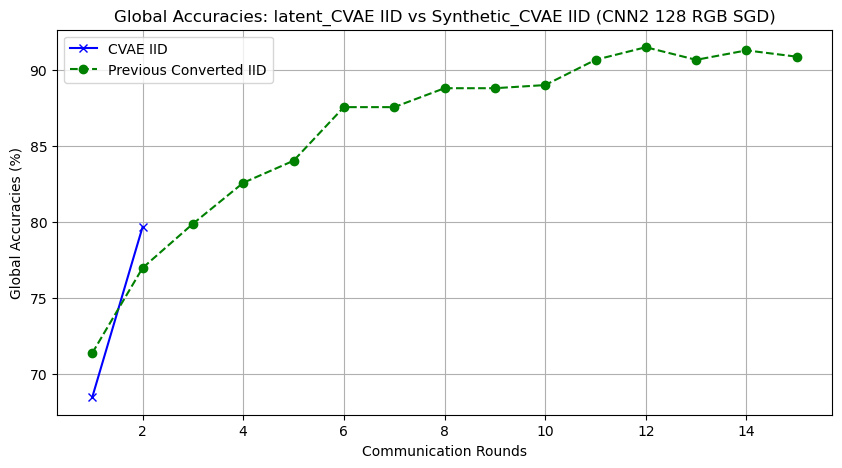

Saved accuracy comparison plot to FL_VEHICLE_CVAE_IID\cnn2_128_500_vehicle_rgb_sgd_accuracy_latent_cvae_iid_vs_synthetic_cvae_iid.png


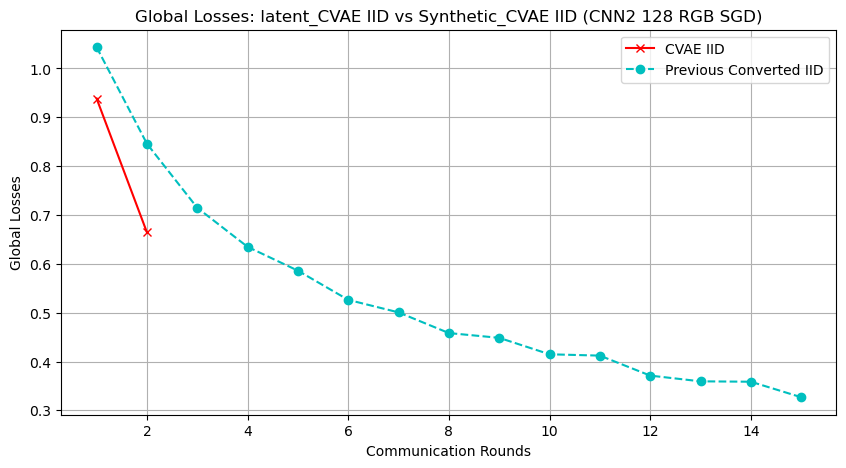

Saved loss comparison plot to FL_VEHICLE_CVAE_IID\cnn2_128_500_vehicle_rgb_sgd_loss_latent_cvae_iid_vs_synthetic_cvae_iid.png

Total time for the entire script: 4m 59.63s


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
from PIL import Image
import csv
import random
import kagglehub
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import pandas as pd
import torchvision.utils as vutils
import time

# Start total script timer
total_start_time = time.time()

# Ensure output directory exists for the new CVAE-based IID setup
output_dir_cvae_iid = "FL_VEHICLE_CVAE_IID"
os.makedirs(output_dir_cvae_iid, exist_ok=True)

# Load the previous converted IID results
prev_converted_iid_path = r"C:\Users\hp\Desktop\fedavg\FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv"
try:
    prev_converted_iid_df = pd.read_csv(prev_converted_iid_path)
    communication_rounds_prev_converted_iid = prev_converted_iid_df['Communication Rounds'].tolist()
    global_accuracies_prev_converted_iid = prev_converted_iid_df['Global Accuracies'].tolist()
    global_losses_prev_converted_iid = prev_converted_iid_df['Global Losses'].tolist()
    print(f"Loaded previous converted IID results from {prev_converted_iid_path}")
except Exception as e:
    print(f"Failed to load previous converted IID results from {prev_converted_iid_path}: {e}")
    raise

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Base transform for RGB Vehicle Type Dataset (used for CNN, expects PIL Image input)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for data that's already a tensor (used for real_data)
tensor_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for CVAE (keep data in [0, 1], flatten spatial dimensions)
cvae_input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # [0, 1]
])
cvae_flatten_transform = transforms.Lambda(lambda x: x.view(x.size(0), -1))

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Original Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        if not self.images:
            raise ValueError(f"No images found in {root_dir}.")

        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the Vehicle Type Dataset with CVAE input transform for splitting
dataset_cvae = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset_cvae.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset_cvae)):
    label = dataset_cvae.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap between train, val, and test
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create datasets for CVAE (train) and CNN (val/test)
train_dataset_cvae = Subset(dataset_cvae, [idx for class_indices in train_indices_per_class for idx in class_indices])
dataset_cnn = VehicleTypeDataset(root_dir=dataset_path, transform=base_transform)
val_dataset = Subset(dataset_cnn, [idx for class_indices in val_indices_per_class for idx in class_indices])
test_dataset = Subset(dataset_cnn, [idx for class_indices in test_indices_per_class for idx in class_indices])

print(f"Training samples (CVAE): {len(train_dataset_cvae)}")
print(f"Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Create per-class training datasets for CVAE and subsample to 500 samples
target_samples_per_class = 500
train_class_datasets = []

for class_idx in range(label_dim):
    # Get the indices for this class
    class_indices = train_indices_per_class[class_idx]
    # Subsample directly from the original dataset to avoid nested Subsets
    if len(class_indices) > target_samples_per_class:
        class_indices = random.sample(class_indices, target_samples_per_class)
    class_dataset = Subset(dataset_cvae, class_indices)
    train_class_datasets.append(class_dataset)
    print(f"Class {class_idx} subsampled dataset length: {len(class_dataset)}")

# CVAE Configuration
original_dim = 128 * 128 * 3  # 128x128 RGB images
intermediate_dim = 512
latent_dim = 256
batch_size = 8
epochs = 2  # Updated as per your change
learning_rate = 1e-4
beta = 0.5
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Define CVAE classes
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, label_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, label_dim, hidden_dim, output_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, y):
        z_mean, z_logvar = self.encoder(x, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

def cvae_loss(x, x_reconstructed, z_mean, z_logvar, beta=beta):
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + beta * kl_loss

# Function to format time in a readable way
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    if hours > 0:
        return f"{hours}h {minutes}m {secs:.2f}s"
    elif minutes > 0:
        return f"{minutes}m {secs:.2f}s"
    else:
        return f"{secs:.2f}s"

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 2],  # User 1
    1: [1, 2, 3],  # User 2
    2: [2, 3, 4],  # User 3
    3: [3, 4, 0],  # User 4
    4: [4, 0, 1]   # User 5
}

cvae_users = {}
for user_idx in range(Num_users):
    # Start timer for this user's CVAE training/loading
    user_start_time = time.time()

    # Create user dataset by combining the class datasets
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    print(f"User {user_idx + 1} dataset length: {len(user_dataset)}")
    
    # Validate indices by accessing a few samples
    try:
        for i in range(min(5, len(user_dataset))):
            sample, label = user_dataset[i]
            print(f"User {user_idx + 1}, Sample {i}: Label={label}, Data shape={sample.shape}")
    except Exception as e:
        print(f"Error accessing samples for User {user_idx + 1}: {e}")
        raise

    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True)
    
    cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    checkpoint_dir = f'C:\\Users\\hp\\Desktop\\fedavg\\checkpoints_cvae_user{user_idx + 1}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'cvae_user{user_idx + 1}_final.pth')
    
    if user_idx == 0:
        # Load the pre-trained model for User 1
        print(f"Loading pre-trained CVAE for User 1 from {checkpoint_path}...")
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            cvae.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Successfully loaded pre-trained CVAE for User 1.")
        except Exception as e:
            print(f"Failed to load pre-trained CVAE for User 1: {e}")
            raise
    else:
        # Train CVAE for other users
        if os.path.exists(checkpoint_path):
            print(f"Loading pre-trained CVAE for User {user_idx + 1}...")
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            cvae.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        else:
            print(f"Training CVAE for User {user_idx + 1}...")
            for epoch in range(epochs):
                # Start timer for this epoch
                epoch_start_time = time.time()

                cvae.train()
                total_loss = 0
                for batch_idx, (data, labels) in enumerate(user_loader):
                    data = data.to(device)
                    data = cvae_flatten_transform(data)
                    y = F.one_hot(labels, num_classes=label_dim).float().to(device)
                    
                    optimizer.zero_grad()
                    x_recon, z_mean, z_logvar = cvae(data, y)
                    loss = cvae_loss(data, x_recon, z_mean, z_logvar)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(user_loader.dataset)
                
                # Calculate and print epoch time
                epoch_time = time.time() - epoch_start_time
                print(f"User {user_idx + 1}, Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {format_time(epoch_time)}")
            
            # Save the trained model
            torch.save({'model_state_dict': cvae.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)
            print(f"CVAE for User {user_idx + 1} saved to {checkpoint_path}.")
    
    cvae_users[user_idx] = cvae

    # Calculate and print total time for this user
    user_time = time.time() - user_start_time
    print(f"Total time for User {user_idx + 1} CVAE {'loading' if user_idx == 0 else 'training'}: {format_time(user_time)}\n")

# Step 3: Save latent vectors and decoder parameters for each class
for user_idx in range(Num_users):
    cvae = cvae_users[user_idx]
    user_folder = f'C:\\Users\\hp\\Desktop\\fedavg\\user{user_idx + 1}_cvae'
    os.makedirs(user_folder, exist_ok=True)
    
    torch.save(cvae.decoder.state_dict(), os.path.join(user_folder, 'decoder.pth'))
    
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=False)
    
    latent_vectors = {cls: {'z_mean': [], 'z_logvar': []} for cls in user_classes[user_idx]}
    
    cvae.eval()
    with torch.no_grad():
        for data, labels in user_loader:
            data = data.to(device)
            data = cvae_flatten_transform(data)
            y = F.one_hot(labels, num_classes=label_dim).float().to(device)
            z_mean, z_logvar = cvae.encoder(data, y)
            for i, label in enumerate(labels):
                latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                latent_vectors[label.item()]['z_logvar'].append(z_logvar[i].cpu())
    
    for cls in user_classes[user_idx]:
        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
        torch.save({'z_mean': z_mean, 'z_logvar': z_logvar}, os.path.join(user_folder, f'class_{cls}_latent.pt'))

# Step 4: Share latent vectors and decoder parameters to generate synthetic data
# Define which users have which classes
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme (choose the first user that has the class as the source)
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # Pick the first user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000  # Generate 1000 images
num_synthetic_per_class_select = 500     # Select 500 images

# Generate synthetic data and select top 500 based on mean pixel intensity
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user_idx = scheme['source_user']
    target_users = scheme['target_users']
    
    # Load latent vectors from the source user
    source_folder = f'C:\\Users\\hp\\Desktop\\fedavg\\user{source_user_idx + 1}_cvae'
    latent_data = torch.load(os.path.join(source_folder, f'class_{class_id}_latent.pt'), weights_only=False)
    print(f"Loaded latent data for User {source_user_idx + 1}, Class {class_id}: z_mean shape = {latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)
    
    # Create a shared CVAE instance for this class
    shared_cvae = CVAE(original_dim, label_dim, intermediate_dim, latent_dim, original_dim).to(device)
    
    # Load decoder parameters
    if scheme['share_decoder']:
        decoder_params = torch.load(os.path.join(source_folder, 'decoder.pth'), weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters for User {source_user_idx + 1}, Class {class_id}")
    else:
        print(f"Warning: No decoder shared for User {source_user_idx + 1}, Class {class_id}. Using random decoder.")
    
    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = f'C:\\Users\\hp\\Desktop\\fedavg\\synthetic_user{user_idx + 1}\\class_{class_id}'
        os.makedirs(synthetic_dir, exist_ok=True)
        
        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []
        
        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()  # Compute mean pixel intensity
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)
                
                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")
        
        # Sort images by mean pixel intensity and select top 500
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]  # Sort in descending order
        selected_indices = sorted_indices[:num_synthetic_per_class_select]
        
        # Save the selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                vutils.save_image(synthetic_images[img_idx].view(3, 128, 128), img_path, normalize=True)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue
        
        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        
        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")
            
            def __len__(self):
                return len(self.image_files)
            
            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label
        
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=base_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 5: Prepare user data with real and synthetic datasets
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    real_data = Subset(real_data, range(len(real_data)))  # Ensure proper indexing
    # Apply tensor_transform since real_data is already a tensor
    real_data = [(tensor_transform(data[0]), data[1]) for data in real_data]
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

# Verify the converted IID distribution
print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

print("\n=== Class Proportion Variance Across Users (CVAE IID) ===")
class_percentages_all_users = np.array([[count / sum(counts) * 100 for count in counts] for counts in class_counts_per_user])
for class_idx in range(label_dim):
    class_proportions = class_percentages_all_users[:, class_idx]
    variance = np.var(class_proportions)
    print(f"Class {class_idx} proportion variance across users (CVAE IID): {variance:.2f}%")
    if variance > 5:
        print(f"Warning: High variance in Class {class_idx} distribution (should be low for IID).")

# CNN Model for RGB
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, label_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Step 6: Run Federated Learning for CVAE IID Setup
batch_size = 128
num_local_epochs = 3
num_rounds = 2  # Updated as per your change

# Start timer for FedAvg process
fedavg_start_time = time.time()

print("\n=== Running Federated Learning (CVAE IID) ===")
global_model_cvae_iid = CNN().to(device)
local_models_cvae_iid = [CNN().to(device) for _ in range(Num_users)]
communication_rounds_cvae_iid = []
global_accuracies_cvae_iid = []
global_losses_cvae_iid = []

for round in range(num_rounds):
    round_start_time = time.time()
    print(f"Round {round + 1} (CVAE IID)")
    for user_idx in range(Num_users):
        local_models_cvae_iid[user_idx].load_state_dict(global_model_cvae_iid.state_dict())
        local_model = local_models_cvae_iid[user_idx]
        local_tr_data_loader = DataLoader(user_data[user_idx], batch_size=batch_size, shuffle=True)
        local_val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_local_epochs):
            local_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for data, target in local_tr_data_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = output.max(1)
                total_train += target.size(0)
                correct_train += predicted.eq(target).sum().item()

            train_loss = running_loss / len(local_tr_data_loader) if len(local_tr_data_loader) > 0 else float('inf')
            train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0.0

            local_model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data, target in local_val_data_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_model(data)
                    val_loss += criterion(output, target).item()
                    _, predicted = output.max(1)
                    total_val += target.size(0)
                    correct_val += predicted.eq(target).sum().item()

            val_loss /= len(local_val_data_loader) if len(local_val_data_loader) > 0 else 1
            val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0.0
            print(f"User {user_idx + 1}, Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
            scheduler.step()

    global_state_dict = global_model_cvae_iid.state_dict()
    for key in global_state_dict.keys():
        local_state_dicts = [local_model.state_dict() for local_model in local_models_cvae_iid]
        global_state_dict[key] = torch.mean(torch.stack([d[key].float() for d in local_state_dicts]), dim=0)
    global_model_cvae_iid.load_state_dict(global_state_dict)

    global_model_cvae_iid.eval()
    global_loss = 0.0
    global_accuracy = 0.0
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = global_model_cvae_iid(data)
            global_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            global_accuracy += (predicted == labels).sum().item()

    global_accuracy = 100 * global_accuracy / len(test_dataset) if len(test_dataset) > 0 else 0.0
    global_loss /= len(test_loader) if len(test_loader) > 0 else 1
    round_time = time.time() - round_start_time
    print(f"Round {round + 1}: Global Test Accuracy (CVAE IID): {global_accuracy:.2f}%, Global Loss: {global_loss:.4f}, Time: {format_time(round_time)}")
    communication_rounds_cvae_iid.append(round + 1)
    global_accuracies_cvae_iid.append(global_accuracy)
    global_losses_cvae_iid.append(global_loss)

# Calculate and print total FedAvg time
fedavg_time = time.time() - fedavg_start_time
print(f"\nTotal time for FedAvg ({num_rounds} rounds): {format_time(fedavg_time)}")  # Updated to reflect actual number of rounds

# Step 7: Save Results for CVAE IID and Compare with Previous Converted IID
# Save CVAE IID Results
model_save_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_rgb_sgd_global_model_cvae_iid.pth")
torch.save(global_model_cvae_iid.state_dict(), model_save_path_cvae_iid)
print(f"CVAE IID global model saved to {model_save_path_cvae_iid}")

csv_file_path_cvae_iid = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_cvae_iid.csv")
with open(csv_file_path_cvae_iid, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Communication Rounds', 'Global Accuracies', 'Global Losses'])
    writer.writerows(zip(communication_rounds_cvae_iid, global_accuracies_cvae_iid, global_losses_cvae_iid))

# Compare CVAE IID and Previous Converted IID: Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_accuracies_cvae_iid, marker='x', linestyle='-', color='b', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_accuracies_prev_converted_iid, marker='o', linestyle='--', color='g', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracies (%)')
plt.title('Global Accuracies: latent_CVAE IID vs Synthetic_CVAE IID (CNN2 128 RGB SGD)')  # Updated as per your change
plt.grid(True)
plt.legend()
comparison_accuracy_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_accuracy_latent_cvae_iid_vs_synthetic_cvae_iid.png")  # Updated as per your change
plt.savefig(comparison_accuracy_plot)
plt.show()
print(f"Saved accuracy comparison plot to {comparison_accuracy_plot}")

# Compare CVAE IID and Previous Converted IID: Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_cvae_iid, global_losses_cvae_iid, marker='x', linestyle='-', color='r', label='CVAE IID')
plt.plot(communication_rounds_prev_converted_iid, global_losses_prev_converted_iid, marker='o', linestyle='--', color='c', label='Previous Converted IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.title('Global Losses: latent_CVAE IID vs Synthetic_CVAE IID (CNN2 128 RGB SGD)')  # Updated as per your change
plt.grid(True)
plt.legend()
comparison_loss_plot = os.path.join(output_dir_cvae_iid, "cnn2_128_500_vehicle_rgb_sgd_loss_latent_cvae_iid_vs_synthetic_cvae_iid.png")  # Updated as per your change
plt.savefig(comparison_loss_plot)
plt.show()
print(f"Saved loss comparison plot to {comparison_loss_plot}")

# Calculate and print total script time
total_time = time.time() - total_start_time
print(f"\nTotal time for the entire script: {format_time(total_time)}")

In [12]:
##testing with low epoches of changed distrinution code

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
import time

# Start total script timer
total_start_time = time.time()

# Ensure output directory exists
output_dir = "FL_VEHICLE_CVAE_latent_test"
os.makedirs(output_dir, exist_ok=True)

# Hyperparameters
RESIZE = 128
original_dim = RESIZE * RESIZE * 3
intermediate_dim = 512
latent_dim = 256
num_classes = 5
batch_size = 8
epochs = 2  # Changed to 2 for testing
learning_rate = 1e-4
beta_start = 1
beta_end = 10
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Print GPU information
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Transform for CVAE (normalize to [-1, 1])
cvae_input_transform = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    try:
                        Image.open(img_path).verify()
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])
                    except:
                        print(f"Skipping corrupted image: {img_path}")

        if len(self.class_names) != num_classes:
            raise ValueError(f"Expected {num_classes} classes, found {len(self.class_names)}")
        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
dataset = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset)):
    label = dataset.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    np.random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create training dataset
train_dataset = Subset(dataset, [idx for class_indices in train_indices_per_class for idx in class_indices])
val_dataset = Subset(dataset, [idx for class_indices in val_indices_per_class for idx in class_indices])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Subsample to 500 samples per class
target_samples_per_class = 500
train_class_datasets = []

for class_idx in range(label_dim):
    class_indices = train_indices_per_class[class_idx]
    if len(class_indices) > target_samples_per_class:
        class_indices = np.random.choice(class_indices, target_samples_per_class, replace=False).tolist()
    class_dataset = Subset(dataset, class_indices)
    train_class_datasets.append(class_dataset)
    print(f"Class {class_idx} subsampled dataset length: {len(class_dataset)}")

# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

# Encoder (Convolutional)
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),    # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2), # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2), # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2), # Output: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2),# Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=5, stride=1, padding=2),# Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.fc_hidden = nn.Linear(1024 * 2 * 2 + num_classes, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.apply(init_weights)

    def forward(self, x, y):
        x = self.encoder_cnn(x)
        x = x.view(x.size(0), -1)
        x_with_y = torch.cat([x, y], dim=-1)
        h = F.relu(self.fc_hidden(x_with_y))
        h = self.dropout(h)
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        z_logvar = torch.clamp(z_logvar, min=-10, max=10)
        return z_mean, z_logvar

# Decoder (Convolutional)
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_classes):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc_to_cnn = nn.Linear(hidden_dim, 1024 * 2 * 2)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, kernel_size=5, stride=1, padding=2), # Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),   # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),     # Output: 3 x 128 x 128
            nn.Tanh()
        )
        self.apply(init_weights)

    def forward(self, z, y):
        z_with_y = torch.cat([z, y], dim=-1)
        h = F.relu(self.fc(z_with_y))
        h = self.dropout(h)
        h = F.relu(self.fc_to_cnn(h))
        h = h.view(-1, 1024, 2, 2)
        x_reconstructed = self.decoder_cnn(h)
        x_reconstructed = torch.clamp(x_reconstructed, min=-1, max=1)
        return x_reconstructed

# Conditional VAE
class ConditionalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConditionalVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, data, y):
        z_mean, z_logvar = self.encoder(data, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

# Loss Function
def cvae_loss(data, x_reconstructed, z_mean, z_logvar, beta=1.0):
    batch_size = data.size(0)
    mse_loss = F.mse_loss(x_reconstructed, data, reduction='sum') / batch_size
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp()) / batch_size
    return mse_loss + beta * kl_loss

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    if hours > 0:
        return f"{hours}h {minutes}m {secs:.2f}s"
    elif minutes > 0:
        return f"{minutes}m {secs:.2f}s"
    else:
        return f"{secs:.2f}s"

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 3],  # User 1
    1: [1, 2, 4],  # User 2
    2: [0, 2, 3],  # User 3
    3: [1, 3, 4],  # User 4
    4: [0, 2, 4]   # User 5
}

cvae_users = {}
train_losses_users = {}
val_losses_users = {}

for user_idx in range(Num_users):
    # Start timer for this user's CVAE training
    user_start_time = time.time()

    # Create user dataset
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    print(f"User {user_idx + 1} dataset length: {len(user_dataset)}")

    # Validate indices
    try:
        for i in range(min(5, len(user_dataset))):
            sample, label = user_dataset[i]
            print(f"User {user_idx + 1}, Sample {i}: Label={label}, Data shape={sample.shape}")
    except Exception as e:
        print(f"Error accessing samples for User {user_idx + 1}: {e}")
        raise

    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

    # Instantiate CVAE
    encoder = Encoder(intermediate_dim, latent_dim, num_classes).to(device)
    decoder = Decoder(latent_dim, intermediate_dim, num_classes).to(device)
    cvae = ConditionalVAE(encoder, decoder).to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    # Training loop
    checkpoint_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{user_idx + 1}')
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_losses = []
    val_losses = []

    cvae.train()
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        beta = beta_start + (beta_end - beta_start) * ((epoch - 1) / (epochs - 1)) if epochs > 1 else beta_end

        train_loss = 0
        batches_processed = 0

        for batch_idx, (data, labels) in enumerate(user_loader):
            try:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)

                optimizer.zero_grad()
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"NaN/Inf loss detected at epoch {epoch}, batch {batch_idx + 1} for User {user_idx + 1}")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(cvae.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
                batches_processed += 1

            except Exception as e:
                print(f"Error at epoch {epoch}, batch {batch_idx + 1} for User {user_idx + 1}: {e}")
                if "out of memory" in str(e).lower():
                    print("Out of memory error detected. Clearing cache...")
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                continue

        avg_train_loss = train_loss / batches_processed if batches_processed > 0 else float('inf')
        train_losses.append(avg_train_loss)

        # Validation
        cvae.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta=1.0)
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f"User {user_idx + 1}, Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {format_time(epoch_time)}")

        scheduler.step()

        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Save checkpoints, latent vectors, and decoder parameters every 500 epochs or at the end
        if epoch % 500 == 0 or epoch == epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f'cvae_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': cvae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }, checkpoint_path)
            print(f"Checkpoint saved for User {user_idx + 1} at epoch {epoch} to {checkpoint_path}")

            # Save decoder parameters
            decoder_dir = os.path.join(checkpoint_dir, 'decoder')
            os.makedirs(decoder_dir, exist_ok=True)
            decoder_path = os.path.join(decoder_dir, f'decoder_epoch_{epoch}.pth')
            torch.save(cvae.decoder.state_dict(), decoder_path)
            print(f"Decoder saved for User {user_idx + 1} at epoch {epoch} to {decoder_path}")

            # Save latent vectors with labels
            latent_dir = os.path.join(checkpoint_dir, f'latent_vectors_epoch_{epoch}')
            os.makedirs(latent_dir, exist_ok=True)

            cvae.eval()
            with torch.no_grad():
                latent_vectors = {cls: {'z_mean': [], 'z_logvar': [], 'labels': []} for cls in user_classes[user_idx]}
                for data, labels in user_loader:
                    data = data.to(device)
                    y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                    z_mean, z_logvar = cvae.encoder(data, y)
                    for i, label in enumerate(labels):
                        latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                        latent_vectors[label.item()]['z_logvar'].append(z_logvar[i].cpu())
                        latent_vectors[label.item()]['labels'].append(label.item())

                for cls in user_classes[user_idx]:
                    if latent_vectors[cls]['z_mean']:
                        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
                        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
                        labels = torch.tensor(latent_vectors[cls]['labels'])
                        save_path = os.path.join(latent_dir, f'class_{cls}.pth')
                        torch.save({
                            'z_mean': z_mean,
                            'z_logvar': z_logvar,
                            'labels': labels
                        }, save_path)
                        print(f"Saved latent vectors for User {user_idx + 1}, Class {cls} at epoch {epoch} to {save_path}")

    # Store losses for plotting
    train_losses_users[user_idx] = train_losses
    val_losses_users[user_idx] = val_losses

    # Plot losses
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'User {user_idx + 1} CVAE Loss')
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(checkpoint_dir, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved for User {user_idx + 1} to {loss_plot_path}")

    cvae_users[user_idx] = cvae

    user_time = time.time() - user_start_time
    print(f"Total time for User {user_idx + 1} CVAE training: {format_time(user_time)}\n")

# Step 3: Share latent vectors and decoder parameters to generate synthetic data
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # First user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000
num_synthetic_per_class_select = 500

# Use the latest latent vectors and decoder (from epoch 2)
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user = scheme['source_user']
    target_users = scheme['target_users']

    # Load the latest latent vectors (epoch 2)
    latent_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{source_user+1}', 'latent_vectors_epoch_2')
    latent_path = os.path.join(latent_dir, f'class_{class_id}.pth')
    latent_data = torch.load(latent_path, weights_only=False)
    print(f"Loaded latent data for User {source_user+1}, Class {class_id}: z_mean shape={latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)

    # Load the latest decoder (epoch 2)
    decoder_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{source_user+1}', 'decoder')
    decoder_path = os.path.join(decoder_dir, 'decoder_epoch_2.pth')
    print(f"Loading decoder for User {source_user + 1}, Class {class_id}")

    # Create shared CVAE instance
    shared_cvae = ConditionalVAE(Encoder(intermediate_dim, latent_dim, num_classes), Decoder(latent_dim, intermediate_dim, num_classes)).to(device)

    if scheme['share_decoder']:
        decoder_params = torch.load(decoder_path, weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters: {decoder_path}")
    else:
        print(f"Warning: No decoder shared for user {source_user + 1}, Class {class_id}. Using random decoder.")

    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = os.path.join(output_dir, f'synthetic_user_{user_idx + 1}', f'class_{class_id}')
        os.makedirs(synthetic_dir, exist_ok=True)

        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []

        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)

                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")

        # Select top 500 images based on mean pixel intensity
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]
        selected_indices = sorted_indices[:num_synthetic_per_class_select]

        # Save selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                img = synthetic_images[img_idx].view(3, RESIZE, RESIZE)
                img = img * 0.5 + 0.5  # Denormalize to [0, 1]
                img = img.clamp(0, 1)
                img = transforms.ToPILImage()(img)
                img.save(img_path)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue

        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")

        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")

            def __len__(self):
                return len(self.image_files)

            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label

        synthetic_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=synthetic_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 4: Verify the converted IID distribution
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

# Calculate and print total script time
total_time = time.time() - total_start_time
print(f"\nTotal time for the entire script: {format_time(total_time)}")

Using device: cuda:1
GPU Name: NVIDIA RTX A5000
GPU Memory Allocated: 0.00 MB
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\Hatchback
Dirs: []
Files (first 5): ['PHOTO_0.jpg', 'PHOTO_1.jpg

In [ ]:
##code_with_3000epoches

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
import time

# Start total script timer
total_start_time = time.time()

# Ensure output directory exists
output_dir = "FL_VEHICLE_CVAE_latent"
os.makedirs(output_dir, exist_ok=True)

# Hyperparameters
RESIZE = 128
original_dim = RESIZE * RESIZE * 3
intermediate_dim = 512
latent_dim = 256
num_classes = 5
batch_size = 8
epochs = 3000
learning_rate = 1e-4
beta_start = 1
beta_end = 10
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Print GPU information
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Transform for CVAE (normalize to [-1, 1])
cvae_input_transform = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    try:
                        Image.open(img_path).verify()
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])
                    except:
                        print(f"Skipping corrupted image: {img_path}")

        if len(self.class_names) != num_classes:
            raise ValueError(f"Expected {num_classes} classes, found {len(self.class_names)}")
        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
dataset = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset)):
    label = dataset.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    np.random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create training dataset
train_dataset = Subset(dataset, [idx for class_indices in train_indices_per_class for idx in class_indices])
val_dataset = Subset(dataset, [idx for class_indices in val_indices_per_class for idx in class_indices])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Subsample to 500 samples per class
target_samples_per_class = 500
train_class_datasets = []

for class_idx in range(label_dim):
    class_indices = train_indices_per_class[class_idx]
    if len(class_indices) > target_samples_per_class:
        class_indices = np.random.choice(class_indices, target_samples_per_class, replace=False).tolist()
    class_dataset = Subset(dataset, class_indices)
    train_class_datasets.append(class_dataset)
    print(f"Class {class_idx} subsampled dataset length: {len(class_dataset)}")

# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

# Encoder (Convolutional)
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),    # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2), # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2), # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2), # Output: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2),# Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=5, stride=1, padding=2),# Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.fc_hidden = nn.Linear(1024 * 2 * 2 + num_classes, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.apply(init_weights)

    def forward(self, x, y):
        x = self.encoder_cnn(x)
        x = x.view(x.size(0), -1)
        x_with_y = torch.cat([x, y], dim=-1)
        h = F.relu(self.fc_hidden(x_with_y))
        h = self.dropout(h)
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        z_logvar = torch.clamp(z_logvar, min=-10, max=10)
        return z_mean, z_logvar

# Decoder (Convolutional)
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_classes):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc_to_cnn = nn.Linear(hidden_dim, 1024 * 2 * 2)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, kernel_size=5, stride=1, padding=2), # Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 512 x 8 x 8
x 8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, stride=2, padding=2, output_padding=1),  # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, stride=2, padding=2, output_padding=1),
            # Output: 128 x 64 x 32
        nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=5, stride=2, padding=2, output_padding=1),
            # Output: 64 x 64 x 64,
    #       nn.BatchNorm2d(64),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, stride=2, padding=2, output_padding=1),
            # Output: 3 x 128 x 128,
            nn.Tanh()
        )
        self.apply(init_weights))

    def forward(self, z, y):
        z_with_y = torch.cat([z], y], dim=-1)
        h = F.relu(self.fc(z_with_y))
        h = self.dropout(h)
        h = F.relu(self.fc_to_cnn(h))
        h = h.view(-1, 1024, 2, 2)
        )
        x_reconstructed = self.decoder_cnn(h)
        x_reconstructed = torch.clamp(x_reconstructed, min=-1, max=1)
        return x_reconstructed

# Conditional VAE
class ConditionalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConditionalVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, data, y):
        z_mean, z_logvar = self.encoder(data, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

# Loss Function
def cvae_loss(data, x_reconstructed, z_mean, z_logvar, beta=1.0):
    batch_size = data.size(0)
    mse_loss = F.mse_loss(x_reconstructed, data, reduction='sum') / batch_size
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp()) / batch_size
    return mse_loss + beta * kl_loss

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    if hours > 0:
        return f"{hours}h {minutes}m {minutes}s"
    elif minutes > 0:
        return f"{minutes}m {secs:.2f}s"
    else:
        return f"{secs:.2f}s"

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 2],  # User 1
    #1: [1, 2, 3],  # User 2
    #2: [2, 3, 4],  # User 3
    #3: [3, 4, 0],  # User 4
    #4: [4, 0, 1]   # User 5
    0: [0, 1, 3],  # User 1 (New Distribution)
    1: [1, 2, 4],   # User 2
    2: [0, 2, 4],   # User 3
    3: [1, 3, 4],   # User 4
    4: [0, 2, 4]   # User 5
}

cvae_users = {}
train_losses_users = {}
val_losses_users = {}

for user_idx in range(Num_users):
    # Start timer for this user's CVAE training
    user_start_time = time.time()

    # Create user dataset
    user_dataset = ConcatDataset([train_class_datasets[i]] for i in user_classes[user_idx]])
    print(f"User {user_idx + 1} dataset length: {len(user_dataset)}")

    # Validate indices
    try:
        for i in range(min(5, len(user_dataset))):
            sample, label = user_dataset[i]
            print(f"User {user_idx + 1}, Sample {i}: Label={label}, Data shape={sample.shape}")

    except Exception as e:
        print(f"Error: accessing samples for User {user_idx + 1}: {e}")
        raise

    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

    # Instantiate CVAE
    encoder = Encoder(intermediate_dim, latent_dim, num_classes).to(device)
    decoder = Decoder(latent_dim, intermediate_dim, num_classes).to(device)
    cvae = ConditionalVAE(encoder, decoder).to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    # Training loop
    checkpoint_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{user_idx + 1}')
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_losses = []
    val_losses = []

    cvae.train()
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        beta = beta_start + (beta_end - beta_start) * ((epoch - 1) / (epochs - 1)) if epochs > 1 else beta_end

        train_loss = 0
        batches_processed = 0

        for batch_idx, (data, labels) in enumerate(user_loader):
            try:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)

                optimizer.zero_grad()
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"NaN/Inf loss detected at epoch {epoch}, batch {batch_idx + 1} for User {user_idx + 1}")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(cvae.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
                batches_processed += 1

            except Exception as e:
                print(f"Error: at epoch {epoch}, batch {batch_idx + 1} for User {user_idx + 1}: {e}")
                if "out of memory" in str(e).lower():
                    print("Out of memory error detected. Clearing cache...")
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                continue

        avg_train_loss = train_loss / batches_processed if batches_processed > 0 else float('inf')
        train_losses.append(avg_train_loss)

        # Validation
        cvae.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta=1.0)
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f"User {user_idx + 1}, Epoch {epoch}/{epochs}, Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {format_time(epoch_time)}")

        scheduler.step()

        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Save checkpoints, latent vectors, and decoder parameters every 500 epochs
        if epoch % 500 == 0 or epoch == epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f'cvae_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': cvae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }, checkpoint_path)
            print(f"Checkpoint saved for User {user_idx + 1} at epoch {epoch} to {checkpoint_path}")

            # Save decoder parameters
            decoder_dir = os.path.join(checkpoint_dir, 'decoder')
            os.makedirs(decoder_dir, exist_ok=True)
            decoder_path = os.path.join(decoder_dir, f'decoder_epoch_{epoch}.pth')
            torch.save(cvae.decoder.state_dict(), decoder_path)
            print(f"Decoder saved for User {user_idx + 1} at epoch {epoch} to {decoder_path}")

            # Save latent vectors with labels
            latent_dir = os.path.join(checkpoint_dir, f'latent_vectors_epoch_{epoch}')
            os.makedirs(latent_dir, exist_ok=True)

            cvae.eval()
            with torch.no_grad():
                latent_vectors = {cls: {'z_mean': [], 'z_logvar': [], 'labels': []} for cls in user_classes[user_idx]}
                for data, labels in user_loader:
                    data = data.to(device)
                    y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                    z_mean, z_logvar = cvae.encoder(data, y)
                    for i, label in enumerate(labels):
                        latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                        latent_vectors.append(z_mean[i].cpu())['z_logvar'].append(z_logvar[i].cpu())
                        latent_vectors[label.item()].append()['labels'].append(label.item())

                for cls in user_classes[user_idx]:
                    if latent_vectors[cls]['z_mean']:
                        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
                        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
                        labels = torch.tensor(latent_vectors[cls]['labels'])
                        save_path = os.path.join(latent_dir, f'class_{cls}.pth')
                        torch.save({
                            'z_mean': z_mean,
                            'z_logvar': z_logvar,
                            'labels': labels
                        }, save_path)
                        print(f"Saved latent vectors for User {user_idx + 1}, Class {cls} at epoch {epoch} to {save_path}")

    # Store losses for plotting
    train_losses_users[user_idx] = train_losses
    val_losses_users[user_idx] = val_losses

    # Plot losses
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'User {user_idx + 1} CVAE Loss')
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(checkpoint_dir, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved for User {user_idx + 1} to {loss_plot_path}")

    cvae_users[user_idx] = cvae

    user_time = time.time() - user_start_time
    print(f"Total time for User {user_idx + 1} CVAE training: {format_time(user_time)}\n")

# Step 3: Share latent vectors and decoder parameters to generate synthetic data
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # First user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000
num_synthetic_per_class_select = 500

# Use the latest latent vectors and decoder (from epoch 3000)
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user = scheme['source_user']
    target_users = scheme['target_users']

    # Load the latest latent vectors (epoch 3000)
    latent_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{source_user+1}', 'latent_vectors_epoch_3000')
    latent_path = os.path.join(latent_dir, f'class_{class_id}.pth')
    latent_data = torch.load(latent_path, weights_only=False)
    print(f"Loaded latent data for User {source_user+1}, Class {class_id}: z_mean shape={latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)

    # Load the latest decoder (epoch 3000)
    decoder_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{source_user+1}', 'decoder')
    decoder_path = os.path.join(decoder_dir, 'decoder_epoch_3000.pth')
    print(f"Loading decoder for User {source_user + 1}, Class {class_id}")

    # Create shared CVAE instance
    shared_cvae = ConditionalVAE(Encoder(intermediate_dim, latent_dim, num_classes), Decoder(latent_dim, intermediate_dim, num_classes)).to(device)

    if scheme['share_decoder']:
        decoder_params = torch.load(decoder_path, weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters: {decoder_path}")
    else:
        print(f"Warning: No decoder shared for user {source_user + 1}, Class {class_id}. Using random decoder.")

    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = os.path.join(output_dir, f'synthetic_user_{user_idx + 1}', f'class_{class_id}')
        os.makedirs(synthetic_dir, exist_ok=True)

        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []

        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)

                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")

        # Select top 500 images based on mean pixel intensity
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]
        selected_indices = sorted_indices[:num_synthetic_per_class_select]

        # Save selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                img = synthetic_images[img_idx].view(3, RESIZE, RESIZE)
                img = img * 0.5 + 0.5  # Denormalize to [0, 1]
                img = img.clamp(0, 1)
                img = transforms.ToPILImage()(img)
                img.save(img_path)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue

        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")

        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")

            def __len__(self):
                return len(self.image_files)

            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label

        synthetic_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=synthetic_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 4: Verify the converted IID distribution
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

# Calculate and print total script time
total_time = time.time() - total_start_time
print(f"\nTotal time for the entire script: {format_time(total_time)}")

In [14]:
##changed code due to problem of 500samples

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
import time

# Start total script timer
total_start_time = time.time()

# Ensure output directory exists
output_dir = "FL_VEHICLE_CVAE_latent"
os.makedirs(output_dir, exist_ok=True)

# Hyperparameters
RESIZE = 128
original_dim = RESIZE * RESIZE * 3
intermediate_dim = 512
latent_dim = 256
num_classes = 5
batch_size = 8
epochs = 3000  # Set to 3000 as requested
learning_rate = 1e-4
beta_start = 1
beta_end = 10
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')

# Print GPU information
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Transform for CVAE (normalize to [-1, 1])
cvae_input_transform = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    try:
                        Image.open(img_path).verify()
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])
                    except:
                        print(f"Skipping corrupted image: {img_path}")

        if len(self.class_names) != num_classes:
            raise ValueError(f"Expected {num_classes} classes, found {len(self.class_names)}")
        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
dataset = VehicleTypeDataset(root_dir=dataset_path, transform=cvae_input_transform)

# Update label_dim
label_dim = len(dataset.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset)):
    label = dataset.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    np.random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create training and validation datasets
train_dataset = Subset(dataset, [idx for class_indices in train_indices_per_class for idx in class_indices])
val_dataset = Subset(dataset, [idx for class_indices in val_indices_per_class for idx in class_indices])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Step 1.5: Ensure 500 samples per class by generating synthetic samples for underrepresented classes
target_samples_per_class = 500
train_class_datasets = []
cvae_per_class = {}

# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

# Encoder (Convolutional)
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),    # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2), # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2), # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2), # Output: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2),# Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=5, stride=1, padding=2),# Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.fc_hidden = nn.Linear(1024 * 2 * 2 + num_classes, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.apply(init_weights)

    def forward(self, x, y):
        x = self.encoder_cnn(x)
        x = x.view(x.size(0), -1)
        x_with_y = torch.cat([x, y], dim=-1)
        h = F.relu(self.fc_hidden(x_with_y))
        h = self.dropout(h)
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        z_logvar = torch.clamp(z_logvar, min=-10, max=10)
        return z_mean, z_logvar

# Decoder (Convolutional)
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_classes):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc_to_cnn = nn.Linear(hidden_dim, 1024 * 2 * 2)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, kernel_size=5, stride=1, padding=2),  # Output: 1024 x 2 x 2
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),  # Output: 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),   # Output: 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),     # Output: 3 x 128 x 128
            nn.Tanh()
        )
        self.apply(init_weights)

    def forward(self, z, y):
        z_with_y = torch.cat([z, y], dim=-1)
        h = F.relu(self.fc(z_with_y))
        h = self.dropout(h)
        h = F.relu(self.fc_to_cnn(h))
        h = h.view(-1, 1024, 2, 2)
        x_reconstructed = self.decoder_cnn(h)
        x_reconstructed = torch.clamp(x_reconstructed, min=-1, max=1)
        return x_reconstructed

# Conditional VAE
class ConditionalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConditionalVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, data, y):
        z_mean, z_logvar = self.encoder(data, y)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z_mean, z_logvar

# Loss Function
def cvae_loss(data, x_reconstructed, z_mean, z_logvar, beta=1.0):
    batch_size = data.size(0)
    mse_loss = F.mse_loss(x_reconstructed, data, reduction='sum') / batch_size
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp()) / batch_size
    return mse_loss + beta * kl_loss

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    if hours > 0:
        return f"{hours}h {minutes}m {secs:.2f}s"
    elif minutes > 0:
        return f"{minutes}m {secs:.2f}s"
    else:
        return f"{secs:.2f}s"

# Generate synthetic samples for classes with fewer than 500 samples
for class_idx in range(label_dim):
    class_indices = train_indices_per_class[class_idx]
    num_real_samples = len(class_indices)
    print(f"Class {class_idx} has {num_real_samples} real samples before augmentation.")

    if num_real_samples >= target_samples_per_class:
        # Subsample to exactly 500 if more than 500
        class_indices = np.random.choice(class_indices, target_samples_per_class, replace=False).tolist()
        class_dataset = Subset(dataset, class_indices)
        train_class_datasets.append(class_dataset)
        print(f"Class {class_idx} subsampled to {len(class_dataset)} samples.")
        continue

    # If fewer than 500, train a CVAE to generate additional samples
    num_synthetic_needed = target_samples_per_class - num_real_samples
    print(f"Generating {num_synthetic_needed} synthetic samples for Class {class_idx} to reach {target_samples_per_class} samples.")

    # Create dataset for this class
    class_dataset = Subset(dataset, class_indices)
    class_loader = DataLoader(class_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

    # Instantiate CVAE for this class
    encoder = Encoder(intermediate_dim, latent_dim, num_classes).to(device)
    decoder = Decoder(latent_dim, intermediate_dim, num_classes).to(device)
    cvae = ConditionalVAE(encoder, decoder).to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    # Training loop for this class
    class_checkpoint_dir = os.path.join(output_dir, f'checkpoints_cvae_class_{class_idx}')
    os.makedirs(class_checkpoint_dir, exist_ok=True)

    train_losses = []
    val_losses = []

    cvae.train()
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        beta = beta_start + (beta_end - beta_start) * ((epoch - 1) / (epochs - 1)) if epochs > 1 else beta_end

        train_loss = 0
        batches_processed = 0

        for batch_idx, (data, labels) in enumerate(class_loader):
            try:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)

                optimizer.zero_grad()
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"NaN/Inf loss detected at epoch {epoch}, batch {batch_idx + 1} for Class {class_idx}")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(cvae.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
                batches_processed += 1

            except Exception as e:
                print(f"Error at epoch {epoch}, batch {batch_idx + 1} for Class {class_idx}: {e}")
                if "out of memory" in str(e).lower():
                    print("Out of memory error detected. Clearing cache...")
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                continue

        avg_train_loss = train_loss / batches_processed if batches_processed > 0 else float('inf')
        train_losses.append(avg_train_loss)

        # Validation
        cvae.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta=1.0)
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f"Class {class_idx}, Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {format_time(epoch_time)}")

        scheduler.step()

        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Save checkpoints and latent vectors every 500 epochs
        if epoch % 500 == 0 or epoch == epochs:
            checkpoint_path = os.path.join(class_checkpoint_dir, f'cvae_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': cvae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }, checkpoint_path)
            print(f"Checkpoint saved for Class {class_idx} at epoch {epoch} to {checkpoint_path}")

            # Save latent vectors with labels
            latent_dir = os.path.join(class_checkpoint_dir, f'latent_vectors_epoch_{epoch}')
            os.makedirs(latent_dir, exist_ok=True)

            cvae.eval()
            with torch.no_grad():
                latent_vectors = {'z_mean': [], 'z_logvar': [], 'labels': []}
                for data, labels in class_loader:
                    data = data.to(device)
                    y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                    z_mean, z_logvar = cvae.encoder(data, y)
                    for i in range(len(labels)):
                        latent_vectors['z_mean'].append(z_mean[i].cpu())
                        latent_vectors['z_logvar'].append(z_logvar[i].cpu())
                        latent_vectors['labels'].append(labels[i].item())

                if latent_vectors['z_mean']:
                    z_mean = torch.stack(latent_vectors['z_mean'])
                    z_logvar = torch.stack(latent_vectors['z_logvar'])
                    labels = torch.tensor(latent_vectors['labels'])
                    save_path = os.path.join(latent_dir, f'class_{class_idx}.pth')
                    torch.save({
                        'z_mean': z_mean,
                        'z_logvar': z_logvar,
                        'labels': labels
                    }, save_path)
                    print(f"Saved latent vectors for Class {class_idx} at epoch {epoch} to {save_path}")

    # Store the trained CVAE for this class
    cvae_per_class[class_idx] = cvae

    # Generate synthetic samples
    synthetic_dir = os.path.join(output_dir, f'synthetic_class_{class_idx}')
    os.makedirs(synthetic_dir, exist_ok=True)

    print(f"Generating {num_synthetic_needed} synthetic images for Class {class_idx}")
    synthetic_images = []
    latent_path = os.path.join(class_checkpoint_dir, 'latent_vectors_epoch_3000', f'class_{class_idx}.pth')
    latent_data = torch.load(latent_path, weights_only=False)
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)

    cvae.eval()
    with torch.no_grad():
        for i in range(num_synthetic_needed):
            z = cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                    z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
            y = F.one_hot(torch.tensor([class_idx]), num_classes=label_dim).float().to(device)
            synthetic_img = cvae.decoder(z, y).cpu()
            synthetic_images.append(synthetic_img)

    # Save synthetic images
    for idx, img in enumerate(synthetic_images):
        img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
        try:
            img = img.view(3, RESIZE, RESIZE)
            img = img * 0.5 + 0.5  # Denormalize to [0, 1]
            img = img.clamp(0, 1)
            img = transforms.ToPILImage()(img)
            img.save(img_path)
            if (idx + 1) % 100 == 0 or idx == 0:
                print(f"Saved {idx + 1} synthetic images for Class {class_idx}")
        except Exception as e:
            print(f"Error saving image {img_path}: {e}")
            continue

    # Create synthetic dataset
    class SyntheticDataset(Dataset):
        def __init__(self, class_label, root_dir, transform=None):
            self.class_label = class_label
            self.root_dir = root_dir
            self.transform = transform
            self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
            if len(self.image_files) == 0:
                raise ValueError(f"No images found in {root_dir}")

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_path = os.path.join(self.root_dir, self.image_files[idx])
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, self.class_label

    synthetic_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    synthetic_dataset = SyntheticDataset(class_idx, synthetic_dir, transform=synthetic_transform)

    # Combine real and synthetic datasets to reach exactly 500 samples
    combined_dataset = ConcatDataset([class_dataset, synthetic_dataset])
    combined_indices = list(range(len(combined_dataset)))
    if len(combined_indices) > target_samples_per_class:
        combined_indices = np.random.choice(combined_indices, target_samples_per_class, replace=False).tolist()
    final_class_dataset = Subset(combined_dataset, combined_indices)
    train_class_datasets.append(final_class_dataset)
    print(f"Class {class_idx} final dataset length: {len(final_class_dataset)}")

# Step 2: Define user classes and train CVAEs
Num_users = 5
user_classes = {
    0: [0, 1, 3],  # User 1
    1: [1, 2, 4],  # User 2
    2: [0, 2, 3],  # User 3
    3: [1, 3, 4],  # User 4
    4: [0, 2, 4]   # User 5
}

cvae_users = {}
train_losses_users = {}
val_losses_users = {}

for user_idx in range(Num_users):
    # Start timer for this user's CVAE training
    user_start_time = time.time()

    # Create user dataset
    user_dataset = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    print(f"User {user_idx + 1} dataset length: {len(user_dataset)}")

    # Validate indices
    try:
        for i in range(min(5, len(user_dataset))):
            sample, label = user_dataset[i]
            print(f"User {user_idx + 1}, Sample {i}: Label={label}, Data shape={sample.shape}")
    except Exception as e:
        print(f"Error accessing samples for User {user_idx + 1}: {e}")
        raise

    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

    # Instantiate CVAE
    encoder = Encoder(intermediate_dim, latent_dim, num_classes).to(device)
    decoder = Decoder(latent_dim, intermediate_dim, num_classes).to(device)
    cvae = ConditionalVAE(encoder, decoder).to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    # Training loop
    checkpoint_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{user_idx + 1}')
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_losses = []
    val_losses = []

    cvae.train()
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        beta = beta_start + (beta_end - beta_start) * ((epoch - 1) / (epochs - 1)) if epochs > 1 else beta_end

        train_loss = 0
        batches_processed = 0

        for batch_idx, (data, labels) in enumerate(user_loader):
            try:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)

                optimizer.zero_grad()
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"NaN/Inf loss detected at epoch {epoch}, batch {batch_idx + 1} for User {user_idx + 1}")
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(cvae.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
                batches_processed += 1

            except Exception as e:
                print(f"Error at epoch {epoch}, batch {batch_idx + 1} for User {user_idx + 1}: {e}")
                if "out of memory" in str(e).lower():
                    print("Out of memory error detected. Clearing cache...")
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                continue

        avg_train_loss = train_loss / batches_processed if batches_processed > 0 else float('inf')
        train_losses.append(avg_train_loss)

        # Validation
        cvae.eval()
        val_loss = 0
        val_batches = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(device)
                y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                x_recon, z_mean, z_logvar = cvae(data, y)
                loss = cvae_loss(data, x_recon, z_mean, z_logvar, beta=1.0)
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        epoch_time = time.time() - epoch_start_time
        print(f"User {user_idx + 1}, Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {format_time(epoch_time)}")

        scheduler.step()

        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Save checkpoints, latent vectors, and decoder parameters every 500 epochs
        if epoch % 500 == 0 or epoch == epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f'cvae_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': cvae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }, checkpoint_path)
            print(f"Checkpoint saved for User {user_idx + 1} at epoch {epoch} to {checkpoint_path}")

            # Save decoder parameters
            decoder_dir = os.path.join(checkpoint_dir, 'decoder')
            os.makedirs(decoder_dir, exist_ok=True)
            decoder_path = os.path.join(decoder_dir, f'decoder_epoch_{epoch}.pth')
            torch.save(cvae.decoder.state_dict(), decoder_path)
            print(f"Decoder saved for User {user_idx + 1} at epoch {epoch} to {decoder_path}")

            # Save latent vectors with labels
            latent_dir = os.path.join(checkpoint_dir, f'latent_vectors_epoch_{epoch}')
            os.makedirs(latent_dir, exist_ok=True)

            cvae.eval()
            with torch.no_grad():
                latent_vectors = {cls: {'z_mean': [], 'z_logvar': [], 'labels': []} for cls in user_classes[user_idx]}
                for data, labels in user_loader:
                    data = data.to(device)
                    y = F.one_hot(labels, num_classes=num_classes).float().to(device)
                    z_mean, z_logvar = cvae.encoder(data, y)
                    for i, label in enumerate(labels):
                        latent_vectors[label.item()]['z_mean'].append(z_mean[i].cpu())
                        latent_vectors[label.item()]['z_logvar'].append(z_logvar[i].cpu())
                        latent_vectors[label.item()]['labels'].append(label.item())

                for cls in user_classes[user_idx]:
                    if latent_vectors[cls]['z_mean']:
                        z_mean = torch.stack(latent_vectors[cls]['z_mean'])
                        z_logvar = torch.stack(latent_vectors[cls]['z_logvar'])
                        labels = torch.tensor(latent_vectors[cls]['labels'])
                        save_path = os.path.join(latent_dir, f'class_{cls}.pth')
                        torch.save({
                            'z_mean': z_mean,
                            'z_logvar': z_logvar,
                            'labels': labels
                        }, save_path)
                        print(f"Saved latent vectors for User {user_idx + 1}, Class {cls} at epoch {epoch} to {save_path}")

    # Store losses for plotting
    train_losses_users[user_idx] = train_losses
    val_losses_users[user_idx] = val_losses

    # Plot losses
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'User {user_idx + 1} CVAE Loss')
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(checkpoint_dir, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved for User {user_idx + 1} to {loss_plot_path}")

    cvae_users[user_idx] = cvae

    user_time = time.time() - user_start_time
    print(f"Total time for User {user_idx + 1} CVAE training: {format_time(user_time)}\n")

# Step 3: Share latent vectors and decoder parameters to generate synthetic data
class_to_users = {cls: [] for cls in range(label_dim)}
for user_idx, classes in user_classes.items():
    for cls in classes:
        class_to_users[cls].append(user_idx)

# Define sharing scheme
sharing_scheme = {}
for cls in range(label_dim):
    target_users = [user_idx for user_idx in range(Num_users) if cls not in user_classes[user_idx]]
    if target_users and class_to_users[cls]:
        source_user = class_to_users[cls][0]  # First user with this class
        sharing_scheme[f'class_{cls}'] = {
            'source_user': source_user,
            'target_users': target_users,
            'share_decoder': True
        }

synthetic_datasets = [[] for _ in range(Num_users)]
num_synthetic_per_class_generate = 1000
num_synthetic_per_class_select = 500

# Use the latest latent vectors and decoder (from epoch 3000)
for class_key, scheme in sharing_scheme.items():
    class_id = int(class_key.split('_')[1])
    source_user = scheme['source_user']
    target_users = scheme['target_users']

    # Load the latest latent vectors (epoch 3000)
    latent_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{source_user+1}', 'latent_vectors_epoch_3000')
    latent_path = os.path.join(latent_dir, f'class_{class_id}.pth')
    latent_data = torch.load(latent_path, weights_only=False)
    print(f"Loaded latent data for User {source_user+1}, Class {class_id}: z_mean shape={latent_data['z_mean'].shape}")
    z_mean_all = latent_data['z_mean'].to(device)
    z_logvar_all = latent_data['z_logvar'].to(device)

    # Load the latest decoder (epoch 3000)
    decoder_dir = os.path.join(output_dir, f'checkpoints_cvae_user_{source_user+1}', 'decoder')
    decoder_path = os.path.join(decoder_dir, 'decoder_epoch_3000.pth')
    print(f"Loading decoder for User {source_user + 1}, Class {class_id}")

    # Create shared CVAE instance
    shared_cvae = ConditionalVAE(Encoder(intermediate_dim, latent_dim, num_classes), Decoder(latent_dim, intermediate_dim, num_classes)).to(device)

    if scheme['share_decoder']:
        decoder_params = torch.load(decoder_path, weights_only=False)
        shared_cvae.decoder.load_state_dict(decoder_params)
        print(f"Loaded decoder parameters: {decoder_path}")
    else:
        print(f"Warning: No decoder shared for user {source_user + 1}, Class {class_id}. Using random decoder.")

    # Generate synthetic data for all target users
    for user_idx in target_users:
        synthetic_dir = os.path.join(output_dir, f'synthetic_user_{user_idx + 1}', f'class_{class_id}')
        os.makedirs(synthetic_dir, exist_ok=True)

        print(f"Generating {num_synthetic_per_class_generate} synthetic images for User {user_idx + 1}, Class {class_id}")
        synthetic_images = []
        mean_intensities = []

        shared_cvae.eval()
        with torch.no_grad():
            for i in range(num_synthetic_per_class_generate):
                z = shared_cvae.reparameterize(z_mean_all[i % len(z_mean_all)].unsqueeze(0), 
                                               z_logvar_all[i % len(z_mean_all)].unsqueeze(0))
                y = F.one_hot(torch.tensor([class_id]), num_classes=label_dim).float().to(device)
                synthetic_img = shared_cvae.decoder(z, y).cpu()
                mean_intensity = synthetic_img.mean().item()
                synthetic_images.append(synthetic_img)
                mean_intensities.append(mean_intensity)

                if (i + 1) % 200 == 0:
                    print(f"Generated {i + 1} images for User {user_idx + 1}, Class {class_id}")

        # Select top 500 images based on mean pixel intensity
        print(f"Selecting top {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")
        sorted_indices = np.argsort(mean_intensities)[::-1]
        selected_indices = sorted_indices[:num_synthetic_per_class_select]

        # Save selected images
        for idx, img_idx in enumerate(selected_indices):
            img_path = os.path.join(synthetic_dir, f'image_{idx + 1}.png')
            try:
                img = synthetic_images[img_idx].view(3, RESIZE, RESIZE)
                img = img * 0.5 + 0.5  # Denormalize to [0, 1]
                img = img.clamp(0, 1)
                img = transforms.ToPILImage()(img)
                img.save(img_path)
                if (idx + 1) % 100 == 0 or idx == 0:
                    print(f"Saved {idx + 1} selected images for User {user_idx + 1}, Class {class_id}")
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")
                continue

        print(f"Completed generating and selecting {num_synthetic_per_class_select} images for User {user_idx + 1}, Class {class_id}")

        class SyntheticDataset(Dataset):
            def __init__(self, class_label, root_dir, transform=None):
                self.class_label = class_label
                self.root_dir = root_dir
                self.transform = transform
                self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.png')])
                if len(self.image_files) == 0:
                    raise ValueError(f"No images found in {root_dir}")

            def __len__(self):
                return len(self.image_files)

            def __getitem__(self, idx):
                img_path = os.path.join(self.root_dir, self.image_files[idx])
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, self.class_label

        synthetic_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        synthetic_dataset = SyntheticDataset(class_id, synthetic_dir, transform=synthetic_transform)
        synthetic_datasets[user_idx].append(synthetic_dataset)

# Step 4: Verify the converted IID distribution
user_data = []
for user_idx in range(Num_users):
    real_data = ConcatDataset([train_class_datasets[i] for i in user_classes[user_idx]])
    if synthetic_datasets[user_idx]:
        user_data.append(ConcatDataset([real_data] + synthetic_datasets[user_idx]))
    else:
        user_data.append(real_data)

print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user = []
for user_idx in range(Num_users):
    user_dataset = user_data[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user.append(class_counts)
    print(f"User {user_idx + 1} (CVAE IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (CVAE IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

# Calculate and print total script time
total_time = time.time() - total_start_time
print(f"\nTotal time for the entire script: {format_time(total_time)}")

Using device: cuda:1
GPU Name: NVIDIA RTX A5000
GPU Memory Allocated: 0.00 MB
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\Hatchback
Dirs: []
Files (first 5): ['PHOTO_0.jpg', 'PHOTO_1.jpg

KeyboardInterrupt: 